# Predicción de precios de vehículos usados

En este proyecto, se usará el conjunto de datos de *Car Listings* de Kaggle, donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables tales como el año, la marca, el modelo, entre otras. El objetivo es predecir el precio del automóvil a partir de dichas características.

## Importación de librerías

Se importarán las librerías que se usarán para el desarrollo de este proyecto.

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import joblib
from flask import Flask
from flask_restplus import Api, Resource, fields

import warnings
warnings.filterwarnings('ignore')

## Cargue del conjunto de datos de entrenamiento y de prueba

En seguida, se cargará el conjunto de datos de entrenamiento y de prueba y se visualizarán sus encabezados.

In [2]:
train = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')
test = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTest_carListings.zip',
                   index_col = 0)
print('Conjunto de datos de entrenamiento')
display(train.head())
print('\nConjunto de datos de prueba')
display(test.head())

Conjunto de datos de entrenamiento


,Price,Year,Mileage,State,Make,Model
0,34995,2017,9913,FL,Jeep,Wrangler
1,37895,2015,20578,OH,Chevrolet,Tahoe4WD
2,18430,2012,83716,TX,BMW,X5AWD
3,24681,2014,28729,OH,Cadillac,SRXLuxury
4,26998,2013,64032,CO,Jeep,Wrangler



Conjunto de datos de prueba


,Year,Mileage,State,Make,Model
ID,,,,,
0,2014,31909,MD,Nissan,MuranoAWD
1,2017,5362,FL,Jeep,Wrangler
2,2014,50300,OH,Ford,FlexLimited
3,2004,132160,WA,BMW,5
4,2015,25226,MA,Jeep,Grand


## Preprocesamiento de datos

### Tratamiento de variables categóricas

En esta sección, se definirá la forma en la que se tratarán las variables categóricas del conjunto de datos de entrenamiento. Sin embargo, antes de iniciar con esto, se consultará el número de clases que tienen cada una de ellas.

In [3]:
[[i, len(train.loc[:, i].unique())] for i in train.columns if train.loc[:, i].dtypes == 'O']

[['State', 51], ['Make', 38], ['Model', 525]]

Se puede observar que la cantidad de clases de cada una de las variables categóricas es alto, por lo que no es muy conveniente transformar dichas variables en dummy. Por lo tanto, se asignará un número entero único a cada una de las clases.

In [4]:
train.iloc[:, 3:] = train.iloc[:, 3:].apply(LabelEncoder().fit_transform)
train.head()

,Price,Year,Mileage,State,Make,Model
0,34995,2017,9913,9,17,489
1,37895,2015,20578,35,6,448
2,18430,2012,83716,43,2,499
3,24681,2014,28729,35,5,398
4,26998,2013,64032,5,17,489


### Definición de variables predictoras y de variable de respuesta

Ahora, se definirán las variables predictoras y la variable de respuesta del conjunto de datos de entrenamiento y se convertirán en arreglos Numpy.

In [5]:
X = np.array(train.loc[:, train.columns != 'Price'])
y = np.array(train.loc[:, 'Price'])

### Partición del conjunto de datos de entrenamiento en un set de train y test

A continuación, se partirá el conjunto de datos de entrenamiento en un set de train y de test.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state = 0)

## Calibración de los modelos de regresión

Para este proyecto, se utilizarán dos modelos de ensamblaje: Random Forest y XGBoost. En dichos modelos, se realizarán predicciones sin calibrarlos, es decir, no se definirá ningún parámetro, y calibrándolos, en donde se buscarán los valores de algunos parámetros que mejoran el desempeño de los modelos.

El desempeño de los modelos se evaluará con el MAE (Mean Absolute Error) y se escogerá aquel que tenga el menor valor.

In [7]:
lista_RMSE = []
lista_MAE = []

### Random Forest sin calibrar

In [8]:
np.random.seed(123)

# Implementación y ajuste del modelo de regresión de Random Forest sin calibrar con el set de train 
RF_reg = RandomForestRegressor(n_jobs = -1).fit(X_train, y_train)

# Predicción con el set de test
y_pred = RF_reg.predict(X_test)

# Cálculo del desempeño del modelo utilizando el RMSE y el MAE
RMSE_RF = round(metrics.mean_squared_error(y_pred, y_test, squared = False))
MAE_RF = round(metrics.mean_absolute_error(y_pred, y_test))
print(f'El RMSE del modelo es de {RMSE_RF}')
print(f'El MAE del modelo es de {MAE_RF}')

# Se guardan los valores del RMSE y del MAE obtenidos
lista_RMSE.append(RMSE_RF)
lista_MAE.append(MAE_RF)

El RMSE del modelo es de 3804
El MAE del modelo es de 2379


### Random Forest calibrado

En esta parte, se buscarán los valores de algunos parámetros que mejor calibren el modelo de Random Forest. Para este caso, se evaluarán a partir del RMSE y se escogerán aquellos que tengan la métrica más baja.

#### Parámetro *max_depth*

El parámetro max_depth que mejor calibra el modelo es 17


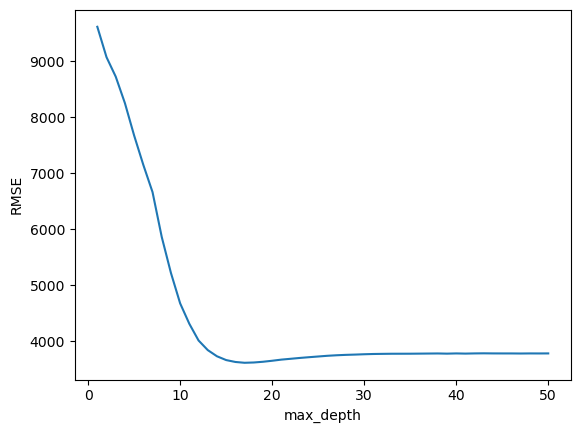

In [9]:
np.random.seed(123)

# Creación de lista para iterar sobre diferentes valores de max_depth
RF_max_depth_range = range(1, 51)

# Definición de lista para almacenar el RMSE promedio de cada valor de max_depth
RMSE_RF_max_depth = []

# Uso de un 5-fold cross-validation para cada valor de max_depth
for max_depth in RF_max_depth_range:
    reg = RandomForestRegressor(n_jobs = -1,
                                max_depth = max_depth)
    RMSE_RF_max_depth.append(
        np.mean(np.sqrt(np.abs(cross_val_score(reg, X_train, y_train, cv = 5, scoring = 'neg_mean_squared_error')))))

# Gráfica del desempeño del modelo para cada valor definido de max_depth
plt.plot(RF_max_depth_range, RMSE_RF_max_depth)
plt.xlabel('max_depth')
plt.ylabel('RMSE')

# Parámetro max_depth que mejor calibra el modelo
best_RF_max_depth = RF_max_depth_range[RMSE_RF_max_depth.index(min(RMSE_RF_max_depth))]
print(f'El parámetro max_depth que mejor calibra el modelo es {best_RF_max_depth}')

#### Parámetro *n_estimators*

El parámetro n_estimators que mejor calibra el modelo es 490


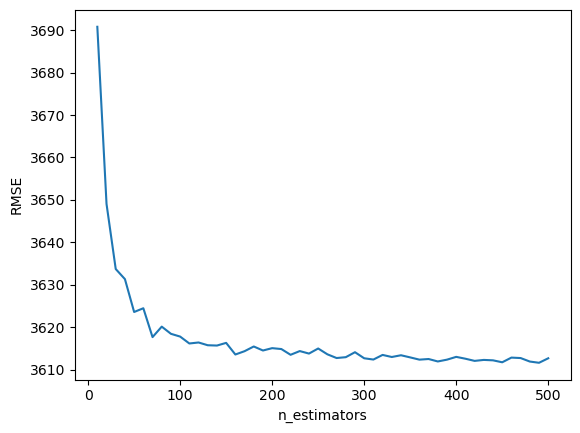

In [10]:
np.random.seed(123)

# Creación de lista para iterar sobre diferentes valores de n_estimators
RF_n_estimators_range = range(10, 510, 10)

# Definición de lista para almacenar el RMSE promedio de cada valor de n_estimators
RMSE_RF_n_estimators = []

# Uso de un 5-fold cross-validation para cada valor de n_estimators
for n_estimators in RF_n_estimators_range:
    reg = RandomForestRegressor(n_jobs = -1,
                                max_depth = best_RF_max_depth,
                                n_estimators = n_estimators)
    RMSE_RF_n_estimators.append(
        np.mean(np.sqrt(np.abs(cross_val_score(reg, X_train, y_train, cv = 5, scoring = 'neg_mean_squared_error')))))

# Gráfica del desempeño del modelo para cada valor definido de n_estimators
plt.plot(RF_n_estimators_range, RMSE_RF_n_estimators)
plt.xlabel('n_estimators')
plt.ylabel('RMSE')

# Parámetro n_estimators que mejor calibra el modelo
best_RF_n_estimators = RF_n_estimators_range[RMSE_RF_n_estimators.index(min(RMSE_RF_n_estimators))]
print(f'El parámetro n_estimators que mejor calibra el modelo es {best_RF_n_estimators}')

#### Parámetro *min_samples_leaf*

El parámetro min_samples_leaf que mejor calibra el modelo es 4


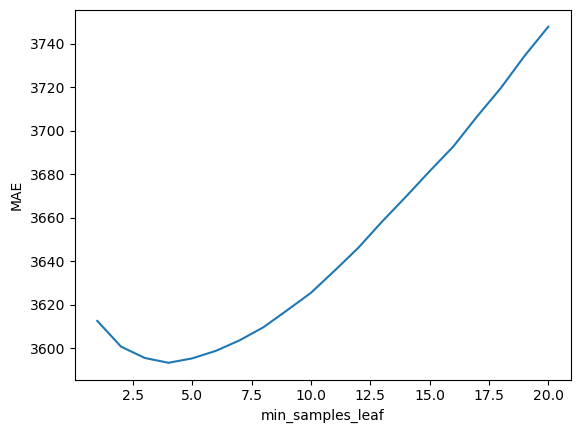

In [11]:
np.random.seed(123)

# Creación de lista para iterar sobre diferentes valores de min_samples_leaf
RF_min_samples_leaf_range = range(1, 21)

# Definición de lista para almacenar el RMSE promedio de cada valor de min_samples_leaf
RMSE_RF_min_samples_leaf = []

# Uso de un 5-fold cross-validation para cada valor de min_samples_leaf
for min_samples_leaf in RF_min_samples_leaf_range:
    reg = RandomForestRegressor(n_jobs = -1,
                                max_depth = best_RF_max_depth,
                                n_estimators = best_RF_n_estimators,
                                min_samples_leaf = min_samples_leaf)
    RMSE_RF_min_samples_leaf.append(
        np.mean(np.sqrt(np.abs(cross_val_score(reg, X_train, y_train, cv = 5, scoring = 'neg_mean_squared_error')))))

# Gráfica del desempeño del modelo para cada valor definido de min_samples_leaf
plt.plot(RF_min_samples_leaf_range, RMSE_RF_min_samples_leaf)
plt.xlabel('min_samples_leaf')
plt.ylabel('MAE')

# Parámetro min_samples_leaf que mejor calibra el modelo
best_RF_min_samples_leaf = RF_min_samples_leaf_range[RMSE_RF_min_samples_leaf.index(min(RMSE_RF_min_samples_leaf))]
print(f'El parámetro min_samples_leaf que mejor calibra el modelo es {best_RF_min_samples_leaf}')

#### Parámetro *min_samples_split*

El parámetro min_samples_split que mejor calibra el modelo es 17


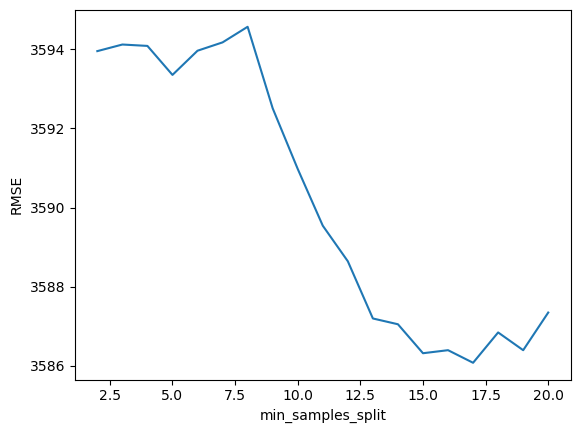

In [12]:
np.random.seed(123)

# Creación de lista para iterar sobre diferentes valores de min_samples_split
RF_min_samples_split_range = range(2, 21)

# Definición de lista para almacenar el RMSE promedio de cada valor de min_samples_split
RMSE_RF_min_samples_split = []

# Uso de un 5-fold cross-validation para cada valor de min_samples_split
for min_samples_split in RF_min_samples_split_range:
    reg = RandomForestRegressor(n_jobs = -1,
                                max_depth = best_RF_max_depth,
                                n_estimators = best_RF_n_estimators,
                                min_samples_leaf = best_RF_min_samples_leaf,
                                min_samples_split = min_samples_split)
    RMSE_RF_min_samples_split.append(
        np.mean(np.sqrt(np.abs(cross_val_score(reg, X_train, y_train, cv = 5, scoring = 'neg_mean_squared_error')))))

# Gráfica del desempeño del modelo para cada valor definido de min_samples_split
plt.plot(RF_min_samples_split_range, RMSE_RF_min_samples_split)
plt.xlabel('min_samples_split')
plt.ylabel('RMSE')

# Parámetro min_samples_split que mejor calibra el modelo
best_RF_min_samples_split = RF_min_samples_split_range[RMSE_RF_min_samples_split.index(min(RMSE_RF_min_samples_split))]
print(f'El parámetro min_samples_split que mejor calibra el modelo es {best_RF_min_samples_split}')

In [13]:
np.random.seed(123)

# Implementación y ajuste del modelo de regresión de Random Forest calibrado con el set de train 
RFC_reg = RandomForestRegressor(n_jobs = -1,
                                max_depth = best_RF_max_depth,
                                n_estimators = best_RF_n_estimators,
                                min_samples_leaf = best_RF_min_samples_leaf,
                                min_samples_split = best_RF_min_samples_split).fit(X_train, y_train)

# Predicción con el set de test
y_pred = RFC_reg.predict(X_test)

# Cálculo del desempeño del modelo utilizando el RMSE y el MAE
RMSE_RFC = round(metrics.mean_squared_error(y_pred, y_test, squared = False))
MAE_RFC = round(metrics.mean_absolute_error(y_pred, y_test))
print(f'El RMSE del modelo es de {RMSE_RFC}')
print(f'El MAE del modelo es de {MAE_RFC}')

# Se guardan los valores del RMSE y del MAE obtenidos
lista_RMSE.append(RMSE_RFC)
lista_MAE.append(MAE_RFC)

El RMSE del modelo es de 3589
El MAE del modelo es de 2278


### XGBoost sin calibrar

In [14]:
np.random.seed(123)

# Implementación y ajuste del modelo de regresión de Random Forest sin calibrar con el set de train 
XGB_reg = XGBRegressor(n_jobs = -1).fit(X_train, y_train)

# Predicción con el set de test
y_pred = XGB_reg.predict(X_test)

# Cálculo del desempeño del modelo utilizando el RMSE y el MAE
RMSE_XGB = round(metrics.mean_squared_error(y_pred, y_test, squared = False))
MAE_XGB = round(metrics.mean_absolute_error(y_pred, y_test))
print(f'El RMSE del modelo es de {RMSE_XGB}')
print(f'El MAE del modelo es de {MAE_XGB}')

# Se guardan los valores del RMSE y del MAE obtenidos
lista_RMSE.append(RMSE_XGB)
lista_MAE.append(MAE_XGB)

El RMSE del modelo es de 3711
El MAE del modelo es de 2446


### XGBoost calibrado

En esta sección, se buscarán los valores de algunos parámetros que mejor calibren el modelo de XGBoost. Para ello, se evaluarán a partir del RMSE y se escogerán aquellos que tengan la métrica más baja.

#### Parámetro *max_depth*

El parámetro max_depth que mejor calibra el modelo es 9


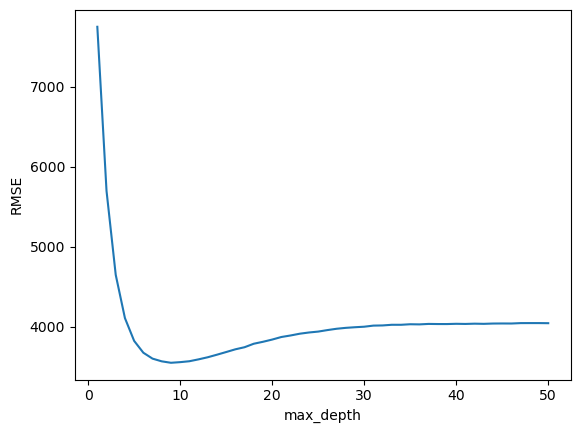

In [15]:
np.random.seed(123)

# Creación de lista para iterar sobre diferentes valores de max_depth
XGB_max_depth_range = range(1, 51)

# Definición de lista para almacenar el RMSE promedio de cada valor de max_depth
RMSE_XGB_max_depth = []

# Uso de un 5-fold cross-validation para cada valor de max_depth
for max_depth in XGB_max_depth_range:
    reg = XGBRegressor(n_jobs = -1,
                       max_depth = max_depth)
    RMSE_XGB_max_depth.append(
        np.mean(np.sqrt(np.abs(cross_val_score(reg, X_train, y_train, cv = 5, scoring = 'neg_mean_squared_error')))))

# Gráfica del desempeño del modelo para cada valor definido de max_depth
plt.plot(XGB_max_depth_range, RMSE_XGB_max_depth)
plt.xlabel('max_depth')
plt.ylabel('RMSE')

# Parámetro max_depth que mejor calibra el modelo
XGB_best_max_depth = XGB_max_depth_range[RMSE_XGB_max_depth.index(min(RMSE_XGB_max_depth))]
print(f'El parámetro max_depth que mejor calibra el modelo es {XGB_best_max_depth}')

#### Parámetro *learning_rate*

El parámetro learning_rate que mejor calibra el modelo es 0.23


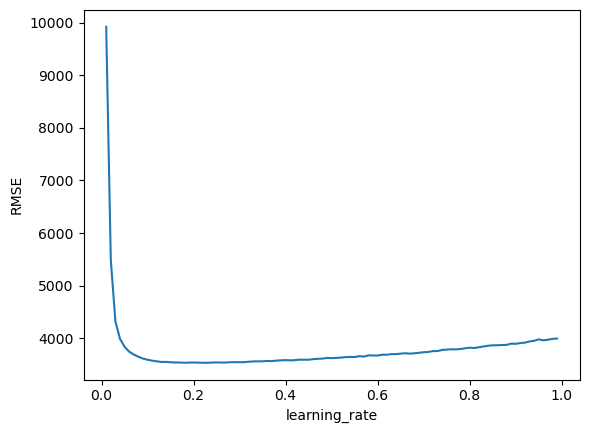

In [16]:
np.random.seed(123)

# Creación de lista para iterar sobre diferentes valores de learning_rate
XGB_learning_rate_range = np.arange(0.01, 1, 0.01)

# Definición de lista para almacenar el RMSE promedio de cada valor de learning_rate
RMSE_XGB_learning_rate = []

# Uso de un 5-fold cross-validation para cada valor de learning_rate
for learning_rate in XGB_learning_rate_range:
    reg = XGBRegressor(n_jobs = -1,
                       max_depth = XGB_best_max_depth,
                       learning_rate = learning_rate)
    RMSE_XGB_learning_rate.append(
        np.mean(np.sqrt(np.abs(cross_val_score(reg, X_train, y_train, cv = 5, scoring = 'neg_mean_squared_error')))))

# Gráfica del desempeño del modelo para cada valor definido de learning_rate
plt.plot(XGB_learning_rate_range, RMSE_XGB_learning_rate)
plt.xlabel('learning_rate')
plt.ylabel('RMSE')

# Parámetro learning_rate que mejor calibra el modelo
XGB_best_learning_rate = XGB_learning_rate_range[RMSE_XGB_learning_rate.index(min(RMSE_XGB_learning_rate))]
print(f'El parámetro learning_rate que mejor calibra el modelo es {XGB_best_learning_rate}')

#### Parámetro *n_estimators*

El parámetro n_estimators que mejor calibra el modelo es 150


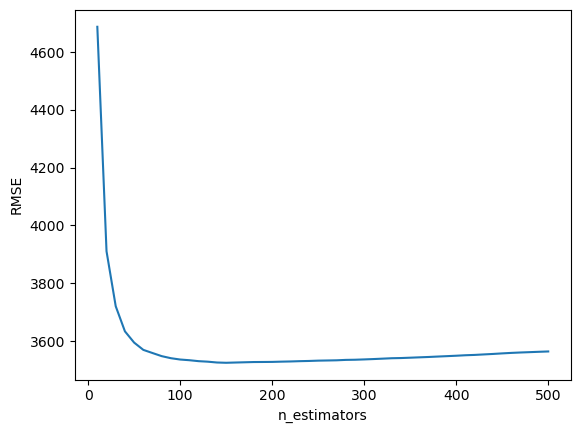

In [17]:
np.random.seed(123)

# Creación de lista para iterar sobre diferentes valores de n_estimators
XGB_n_estimators_range = range(10, 510, 10)

# Definición de lista para almacenar el RMSE promedio de cada valor de n_estimators
RMSE_XGB_n_estimators = []

# Uso de un 5-fold cross-validation para cada valor de n_estimators
for n_estimators in XGB_n_estimators_range:
    reg = XGBRegressor(n_jobs = -1,
                       max_depth = XGB_best_max_depth,
                       learning_rate = XGB_best_learning_rate,
                       n_estimators = n_estimators)
    RMSE_XGB_n_estimators.append(
        np.mean(np.sqrt(np.abs(cross_val_score(reg, X_train, y_train, cv = 5, scoring = 'neg_mean_squared_error')))))

# Gráfica del desempeño del modelo para cada valor definido de n_estimators
plt.plot(XGB_n_estimators_range, RMSE_XGB_n_estimators)
plt.xlabel('n_estimators')
plt.ylabel('RMSE')

# Parámetro n_estimators que mejor calibra el modelo
XGB_best_n_estimators = XGB_n_estimators_range[RMSE_XGB_n_estimators.index(min(RMSE_XGB_n_estimators))]
print(f'El parámetro n_estimators que mejor calibra el modelo es {XGB_best_n_estimators}')

#### Parámetro *gamma* 

El parámetro gamma que mejor calibra el modelo es 30


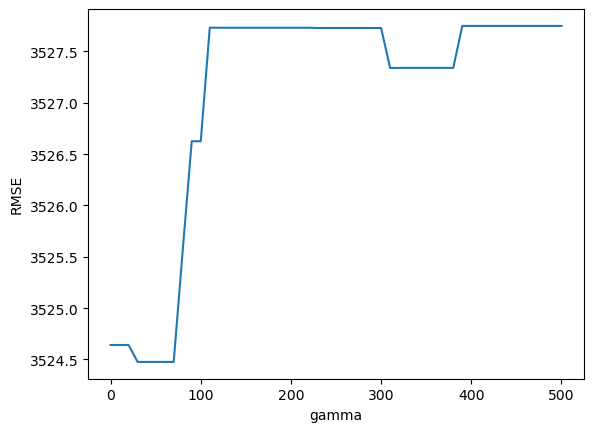

In [18]:
np.random.seed(123)

# Creación de lista para iterar sobre diferentes valores de gamma
XGB_gamma_range = range(0, 501, 10)

# Definición de lista para almacenar el RMSE promedio de cada valor de gamma
RMSE_XGB_gamma = []

# Uso de un 5-fold cross-validation para cada valor de gamma
for gamma in XGB_gamma_range:
    reg = XGBRegressor(n_jobs = -1,
                       max_depth = XGB_best_max_depth,
                       learning_rate = XGB_best_learning_rate,
                       n_estimators = XGB_best_n_estimators,
                       gamma = gamma)
    RMSE_XGB_gamma.append(
        np.mean(np.sqrt(np.abs(cross_val_score(reg, X_train, y_train, cv = 5, scoring = 'neg_mean_squared_error')))))

# Gráfica del desempeño del modelo para cada valor definido de gamma
plt.plot(XGB_gamma_range, RMSE_XGB_gamma)
plt.xlabel('gamma')
plt.ylabel('RMSE')

# Parámetro gamma que mejor calibra el modelo
XGB_best_gamma = XGB_gamma_range[RMSE_XGB_gamma.index(min(RMSE_XGB_gamma))]
print(f'El parámetro gamma que mejor calibra el modelo es {XGB_best_gamma}')

#### Parámetro *colsample_bytree* 

El parámetro colsample_bytree que mejor calibra el modelo es 0.8


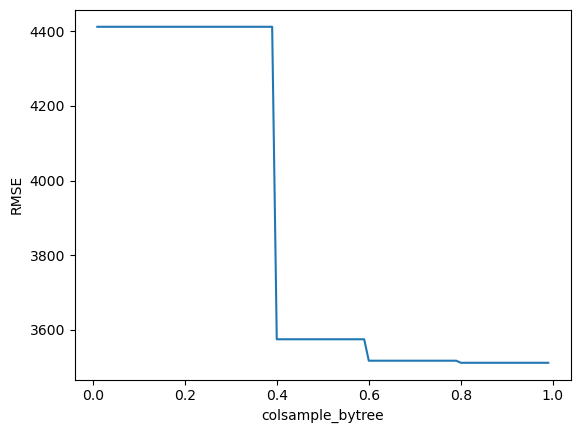

In [19]:
np.random.seed(123)

# Creación de lista para iterar sobre diferentes valores de colsample_bytree
XGB_colsample_bytree_range = np.arange(0.01, 1, 0.01)

# Definición de lista para almacenar el RMSE promedio de cada valor de colsample_bytree
RMSE_XGB_colsample_bytree = []

# Uso de un 5-fold cross-validation para cada valor de colsample_bytree
for colsample_bytree in XGB_colsample_bytree_range:
    reg = XGBRegressor(n_jobs = -1,
                       max_depth = XGB_best_max_depth,
                       learning_rate = XGB_best_learning_rate,
                       n_estimators = XGB_best_n_estimators,
                       gamma = XGB_best_gamma,
                       colsample_bytree = colsample_bytree)
    RMSE_XGB_colsample_bytree.append(
        np.mean(np.sqrt(np.abs(cross_val_score(reg, X_train, y_train, cv = 5, scoring = 'neg_mean_squared_error')))))

# Gráfica del desempeño del modelo para cada valor definido de colsample_bytree
plt.plot(XGB_colsample_bytree_range, RMSE_XGB_colsample_bytree)
plt.xlabel('colsample_bytree')
plt.ylabel('RMSE')

# Parámetro colsample_bytree que mejor calibra el modelo
XGB_best_colsample_bytree = XGB_colsample_bytree_range[RMSE_XGB_colsample_bytree.index(min(RMSE_XGB_colsample_bytree))]
print(f'El parámetro colsample_bytree que mejor calibra el modelo es {XGB_best_colsample_bytree}')

In [20]:
np.random.seed(123)

# Implementación y ajuste del modelo de regresión de XGBoost calibrado con el set de train 
XGBC_reg = XGBRegressor(n_jobs = -1,
                        max_depth = XGB_best_max_depth,
                        learning_rate = XGB_best_learning_rate,
                        n_estimators = XGB_best_n_estimators,
                        gamma = XGB_best_gamma,
                        colsample_bytree = XGB_best_colsample_bytree).fit(X_train, y_train)

# Predicción con el set de test
y_pred = XGBC_reg.predict(X_test)

# Cálculo del desempeño del modelo utilizando el RMSE y el MAE
RMSE_XGBC = round(metrics.mean_squared_error(y_pred, y_test, squared = False))
MAE_XGBC = round(metrics.mean_absolute_error(y_pred, y_test))
print(f'El RMSE del modelo es de {RMSE_XGBC}')
print(f'El MAE del modelo es de {MAE_XGBC}')

# Se guardan los valores del RMSE y del MAE obtenidos
lista_RMSE.append(RMSE_XGBC)
lista_MAE.append(MAE_XGBC)

El RMSE del modelo es de 3523
El MAE del modelo es de 2240


## Comparación de modelos

En esta sección, se compararán las métricas de predicción de cada uno de los modelos de regresión implementados.

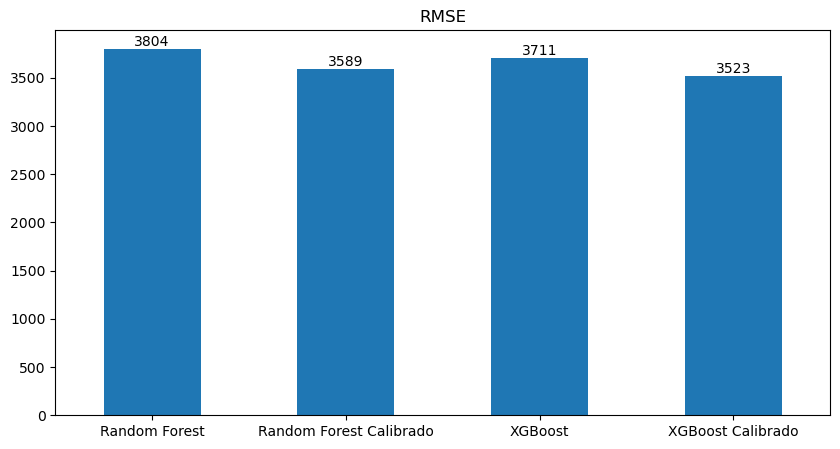

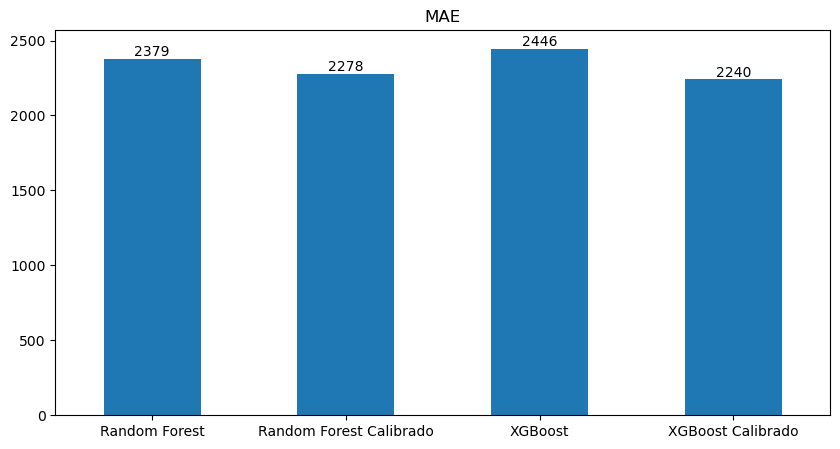

In [23]:
df_RMSE = pd.DataFrame(pd.DataFrame({'Modelo': ['Random Forest',
                                                'Random Forest Calibrado',
                                                'XGBoost',
                                                'XGBoost Calibrado'], 'RMSE': lista_RMSE}))
df_MAE = pd.DataFrame(pd.DataFrame({'Modelo': ['Random Forest',
                                               'Random Forest Calibrado',
                                               'XGBoost',
                                               'XGBoost Calibrado'], 'MAE': lista_MAE}))

ax_RMSE = df_RMSE.plot.bar(x = 'Modelo', y = 'RMSE', rot = 0, figsize = (10, 5), legend = False, xlabel = '', title = 'RMSE')
for container in ax_RMSE.containers:
    ax_RMSE.bar_label(container)

ax_MAE = df_MAE.plot.bar(x = 'Modelo', y = 'MAE', rot = 0, figsize = (10, 5), legend = False, xlabel = '', title = 'MAE')
for container in ax_MAE.containers:
    ax_MAE.bar_label(container)

Las dos gráficas anteriores, permiten observar el RMSE y el MAE de los modelos de Random Forest y XGBoost, ambos sin calibrar y calibrado con diferentes parámetros, en donde ambas muestran que el modelo de XGBoost calibrado no solamente es el que muestra el menor RMSE sino también el menor MAE, por lo que se convierte en el modelo con el mejor desempeño de los cuatro que fueron evaluados.

## Entrenamiento del modelo de regresión seleccionado

A partir del resultado anterior, se selecciona en modelo de XGBoost para entrenarlo con los siguientes parámetros:

- **max_depth** = 9
- **learning_rate** = 0.23
- **n_estimators** = 150
- **gamma** = 30
- **colsample_bytree** = 0.8

In [24]:
np.random.seed(123)

# Implementación y ajuste del modelo de regresión de XGBoost calibrado con el set de train 
XGBC_reg = XGBRegressor(n_jobs = -1,
                        max_depth = XGB_best_max_depth,
                        learning_rate = XGB_best_learning_rate,
                        n_estimators = XGB_best_n_estimators,
                        gamma = XGB_best_gamma,
                        colsample_bytree = XGB_best_colsample_bytree).fit(X_train, y_train)

# Predicción con el set de test
y_pred = XGBC_reg.predict(X_test)

# Cálculo del desempeño del modelo utilizando el RMSE y el MAE
RMSE_XGBC = round(metrics.mean_squared_error(y_pred, y_test, squared = False))
MAE_XGBC = round(metrics.mean_absolute_error(y_pred, y_test))
print(f'El RMSE del modelo es de {RMSE_XGBC}')
print(f'El MAE del modelo es de {MAE_XGBC}')

El RMSE del modelo es de 3523
El MAE del modelo es de 2240


## Exportar modelo

In [27]:
joblib.dump(XGBC_reg, 'regresion.pkl', compress = 3)

['regresion.pkl']

## Disponibilización del modelo

In [29]:
model = joblib.load('regresion.pkl')

# Definición aplicación Flask
app = Flask(__name__)

# Definición API Flask
api = Api(
    app,
    version = '1.0',
    title = 'API PREDICCIÓN PRECIOS VEHÍCULOS USADOS',
    description = 'API que predice el precio de un vehículo usado')

ns = api.namespace('Predicción', description = 'Problema de Regresión')

# Definición argumentos o parámetros de la API
parser = api.parser()
parser.add_argument(
    'Year', 
    type = int, 
    required = True)

parser.add_argument(
    'Mileage', 
    type = int, 
    required = True)

parser.add_argument(
    'State', 
    type = int, 
    required = True)

parser.add_argument(
    'Make', 
    type=int, 
    required=True)

parser.add_argument(
    'Model', 
    type=int, 
    required=True)

resource_fields = api.model('Resource', {
    'result': fields.String,
})

# Definición de la clase para disponibilización
@ns.route('/')
class PredictApi(Resource):

    @api.doc(parser = parser)
    @api.marshal_with(resource_fields)
    def get(self):
        args = parser.parse_args()
        
        return {
         "result": model.predict(np.array([args['Year'],
                                           args['Mileage'],
                                           args['State'],
                                           args['Make'],
                                           args['Model']]).reshape(1, -1))
        }, 200
    
if __name__ == '__main__':
    app.run(debug = True, use_reloader = False, host = '0.0.0.0', port = 5000)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


 * Running on http://0.0.0.0:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [26/Apr/2023 16:17:21] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [26/Apr/2023 16:17:22] "GET /swagger.json HTTP/1.1" 200 -
127.0.0.1 - - [26/Apr/2023 16:18:01] "GET /Predicción/?Year=2017&Mileage=9900&State=5&Make=21&Model=17 HTTP/1.1" 200 -
